# RoPE

在 Transformer 中，常用绝对位置编码(abs) 与 嵌入向量结合作为模型的输入。 两个向量之间通过内积进行交互，表示出相对位置信息：

$$
(E_m+P_m)@(E_n+P_n)^T = E_mE_n^T + E_mP_n^T + P_mE_n^T + P_mP_n^T
$$

其中，向量内积展开式中 $P_mP_n^T$ 可表示成相对位置信息。其他项包含绝对信息，这会导致两个向量受绝对位置影响，例如

- ‘大模型’
- ‘小冬瓜AIGC学大模型’

仅分析两个词元‘大，型’，两个序列中的注意力分数是不同的。这会导致在 1～512 位置范围学好的特征，在 '10000~10512' 表示失效。

须寻找一种理想的表示 $f(m)f(n)^T = f(m-n)$, 其中$f(m)$ 表示关于位置 $m$ 的变换

## Rotate Position Encoding(RoPE) 旋转位置编码

旋转位置编码满足以上要求，

1. 对于每个分组角度，构建2d旋转矩阵，再对特征进行变换。
2. 变换好的特征之间计算注意力分数时，能够显式表示相对距离关系

In [24]:
import torch
import torch.nn as nn
import math
torch.manual_seed(42)

## 2d 旋转

In [33]:
def rotate_2d(theta):
    mat = torch.tensor(
        [[ math.cos(theta), -math.sin(theta)],
        [ math.sin(theta), math.cos(theta)]],
    )
    return mat

vec = torch.tensor([[1.0],[0.0]])
print(vec)
mat = rotate_2d(math.radians(45))     
print(mat)
v_rot = mat @ vec
print(v_rot)

tensor([[1.],
        [0.]])
tensor([[ 0.7071, -0.7071],
        [ 0.7071, -0.7071]])
tensor([[0.7071],
        [0.7071]])


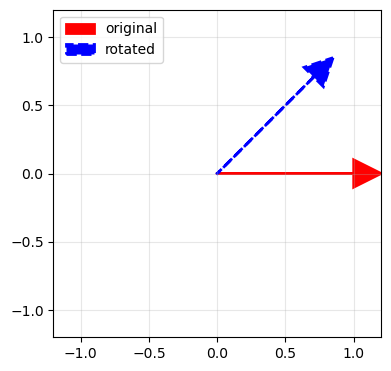

In [34]:
import math
import matplotlib.pyplot as plt
def plot_single_vector_rotation(vec1, vec2):
    """绘制单个向量旋转前后的图像"""
    fig, ax = plt.subplots(figsize=(4, 4))
    
    ax.arrow(0, 0, vec1[0], vec1[1], 
             head_width=0.2, head_length=0.2, 
             fc='red', ec='red', linewidth=2, 
             label='original')
    

    ax.arrow(0, 0, vec2[0], vec2[1], 
             head_width=0.2, head_length=0.2, 
             fc='blue', ec='blue', linewidth=2, linestyle='--',
             label='rotated')
    
    # 设置坐标轴
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal')
    
    # 添加网格和坐标轴
    ax.grid(True, alpha=0.3)
    degrees = math.degrees(theta)
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_single_vector_rotation(vec[:,0], v_rot[:,0])

### 旋转变换线性化

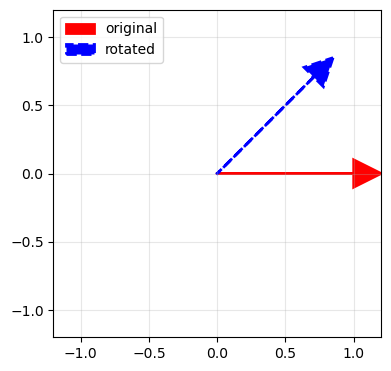

In [37]:
def rotate_2d_linear(theta, x, y):
    sin, cos = math.sin(theta), math.cos(theta)
    x_ = cos * x - sin * y
    y_ = cos * x + cos * y
    return x_, y_

x, y = rotate_2d_linear(math.radians(45), 1.0, 0.0)

plot_single_vector_rotation(vec[:,0], [x,y])

## RoPE 

同理，如果有多个角度 $\theta_i$, 那么每 2 维度都可以做 2D 变换。 

$$
S_{mn, i} = Q_{m,(i)}R(m\theta_i) R^T(n\theta_i)K^T_{n,(i)}
$$

对于 $R^T(n\theta_i)$  旋转转置的转置可以认为是反向旋转， 可以推导有：


$$
R(m\theta_i) R^T(n\theta_i) = R( (m-n) \theta_i)
$$

故对于 mn 位置中的分数 $S_{mn, i} = Q_{m,(i)} R( (m-n) \theta_i)K^T_{n,(i)}$, 即得到了相对位置表示。

In [47]:
d = 512
max_pos = 4096
base = 10000

In [36]:
# total angles 
angles = torch.arange(0, 4, 1) 
m = torch.arange(0, 3, 1) 
m_angles = torch.outer(m, angles)
print(m_angles)

# repeat angles trick
cache = torch.zeros(3, 8)
print(m_angles[:,0::2])
print(m_angles[:,1::2])
cache[:,0::2] = m_angles
cache[:,1::2] = m_angles
print(cache)

tensor([[0, 0, 0, 0],
        [0, 1, 2, 3],
        [0, 2, 4, 6]])
tensor([[0, 0],
        [0, 2],
        [0, 4]])
tensor([[0, 0],
        [1, 3],
        [2, 6]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 2., 2., 3., 3.],
        [0., 0., 2., 2., 4., 4., 6., 6.]])


In [49]:
# broadcast batch dimention

# X = bs, seq_len, d
# pos = seq_len, d
X = torch.zeros( 2, 3, 4)
pos = torch.randn(3, 4) 
result = X + pos
print(result[0,:,:])
print(result[1,:,:])

# None 填充技巧
result = X + pos[None, ...]
print(result[0,:,:])
print(result[1,:,:])

tensor([[ 1.3270, -0.8024,  2.9246, -0.7985],
        [-0.5669, -0.0267, -1.5460, -2.1799],
        [ 0.2074, -1.9844, -0.1817,  0.4280]])
tensor([[ 1.3270, -0.8024,  2.9246, -0.7985],
        [-0.5669, -0.0267, -1.5460, -2.1799],
        [ 0.2074, -1.9844, -0.1817,  0.4280]])
tensor([[ 1.3270, -0.8024,  2.9246, -0.7985],
        [-0.5669, -0.0267, -1.5460, -2.1799],
        [ 0.2074, -1.9844, -0.1817,  0.4280]])
tensor([[ 1.3270, -0.8024,  2.9246, -0.7985],
        [-0.5669, -0.0267, -1.5460, -2.1799],
        [ 0.2074, -1.9844, -0.1817,  0.4280]])


## RoPE 实现

In [42]:
class RoPE(nn.Module):
    def __init__(self, dim = 512, max_pos = 4096, base = 10000.0):
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_pos = max_pos
        
        m = torch.arange(0, self.max_pos, 1)
        i = torch.arange(0, self.dim//2, 1) 
        theta = self.base ** (-2 * i / self.dim)
        m_theta = torch.outer(m, theta)

        self.cos = torch.zeros(self.max_pos, self.dim) 
        self.sin = torch.zeros(self.max_pos, self.dim) 
        self.cos[:, 0::2] = self.cos[:, 1::2] = torch.cos(m_theta) # cos(theta1), cos
        self.sin[:, 0::2] = self.sin[:, 1::2] = torch.sin(m_theta) # sin, sin
        
    def apply_rope(self, X):
        '''
            input: X[bs, n_heads, seq_len, head_dim]
        '''
        bs, n_heads, seq_len, d = X.shape

        X_shift = torch.zeros_like(X)
        X_shift[..., 0::2] = -X[..., 1::2]
        X_shift[..., 1::2] = X[..., 0::2]

        Y = self.cos[None, None, :seq_len, :] * X + \
            self.sin[None, None, :seq_len, :] * X_shift

        return Y

rope = RoPE()

In [43]:
seq_len = 100
bs = 3

Q = torch.randn(bs, seq_len, d).unsqueeze(dim=1) # 单头 Q
rope_q = rope.apply_rope(Q)

In [44]:
n_heads = 8
Q = torch.randn(bs, n_heads, seq_len, d) # 多头 Q
rope_q = rope.apply_rope(Q)

### Attention with RoPE

1. sin, cos 需要 cache 起来，在 model 层面进行存储，可以传参给每一个 decoder block。避免重复存储(sin,cos)占用空间
2. 绝对PE的维度为 `dim`，RoPE 维度是 `head_dim`, 多头 share 一份 RoPE 参数， 注意编程时 batch、n_heads 上并行。
4. KV_cache 存储的是 `apply_rope` 后的 KV

伪代码实现：

```python
class attn:
    def __init__():
        self.wq, self.wk, self.wv, self.wo
        cache_kv = ...

    def forward(X, mask, sin, cos):
        q,k,v = self.wq(X), self.wk(X), self.wv(X)
        q,k,v <- split_head(q), split_head(k), split_head(v)

        # rope in multi-heads qkv
        q,k <- apply_rope(q, sin, cos), apply_rope(k, sin, cos)

        # kv cache
        kv_cache <- k, v

        # multi-head-attention
        # ...

class block:
    def __init__()
        self.ln1
        self.ln2
        self.ffn
        self.attn()
    def forward(X, mask, sin, cos):
        # ...
        X = self.attn(X, mask, sin, cos)
        # ...

class model
    def __init__():
        self.embd = nn.Embedding()
        sin, cos = create_rope_cache(head_dim, max_len)
        self.register_buffer('rope_sin', sin) # 不计梯度
        self.register_buffer('rope_cos', cos)

        self.decoder = [ blocks(dim) for i in range(n_layers)]

    def forward(x,mask):
        bsz, seq_len = x.shape
        X = self.embd(x)
        for block in self.decoder:
            X = block(X, mask,
                    self.rope_sin[:seq_len],
                    self.rope_cos[:seq_len]) # 只传序列部分数据
        # ...
```

## 讨论

1. PE 有什么致命问题？
2. RoPE 性能为什么比 PE 更好？
3. RoPE 衰减性分析？
4. RoPE 的本质是什么？
5. RoPE 的每个维度变换幅度有什么区别？
6. 追溯 PE 来源，简述 无PE RNN、PE 再到 RoPE 发展